In [134]:
import xarray as xr
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [161]:
pc_EL_NINO = xr.open_dataset("/Volumes/YagizHDD/Meteorological-Applications/Data_Analysis_ML/Project_2/pc_EL_NINO.nc") 
pc_NAO = xr.open_dataset("/Volumes/YagizHDD/Meteorological-Applications/Data_Analysis_ML/Project_2/pc_NAO.nc")
precip_df= xr.open_dataset("/Volumes/YagizHDD/Meteorological-Applications/Data_Analysis_ML/Project_2/eu_MED_pr_anomaly.nc") 
surf_wind_df = xr.open_dataset("/Volumes/YagizHDD/Meteorological-Applications/Data_Analysis_ML/Project_2/eu_MED_sfcW_anomaly.nc")
u250_df = xr.open_dataset("/Volumes/YagizHDD/Meteorological-Applications/Data_Analysis_ML/Project_2/eu_MED_ua_anomaly.nc")
v250_df = xr.open_dataset("/Volumes/YagizHDD/Meteorological-Applications/Data_Analysis_ML/Project_2/eu_MED_va_anomaly.nc")

In [ ]:
pc_EL_NINO_ds= pc_EL_NINO.sel(time=slice("1850", "1980"))
pc_NAO_ds= pc_NAO.sel(time=slice("1850", "1980"))
precip_ds = precip_df.sel(time=slice("1850", "1980"))
surf_wind_ds = surf_wind_df.sel(time=slice("1850", "1980"))
u250_ds = u250_df.sel(time=slice("1850", "1980"))
v250_ds = v250_df.sel(time=slice("1850", "1980"))   

In [137]:
pcs_EL_NINO = pc_EL_NINO_ds["pcs"].values 
pcs_NAO = pc_NAO_ds["pcs"].values
precip = precip_ds["pr"].values
surf_wind = surf_wind_ds["sfcWind"].values
u250 = u250_ds["ua"].values
v250 = v250_ds["va"].values

In [138]:
X= np.stack([pcs_EL_NINO[:,0], pcs_NAO[:,0]], axis=1)  # shape (time, n_pcs)
Y = np.stack([precip, surf_wind, u250, v250], axis=1)  # shape (time, 4, lat, lon)

In [139]:
# Original shape: [165, 2]
X_raw = torch.from_numpy(X)  # shape [165, 2]

# Broadcast to shape [165, 2, 32, 64]
X_tensor = X_raw[:, :, None, None].repeat(1, 1, 32, 64)
Y_tensor = torch.tensor(Y, dtype=torch.float32)      

In [140]:
import torch.nn.functional as F

Y_tensor_resized = F.interpolate(Y_tensor, size=(32, 64), mode='bilinear', align_corners=False)

In [141]:
dataset = TensorDataset(X_tensor, Y_tensor_resized)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [142]:
class PCtoAnomalyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 4, kernel_size=1)  # Output 4 channels (variables)
        )

    def forward(self, x):
        return self.cnn(x)

In [143]:
# Instantiate model
model = PCtoAnomalyCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [144]:
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss:.4f}")

Epoch 1/50, Loss: 97.5043
Epoch 2/50, Loss: 96.5005
Epoch 3/50, Loss: 95.7070
Epoch 4/50, Loss: 95.1068
Epoch 5/50, Loss: 93.8793
Epoch 6/50, Loss: 95.0447
Epoch 7/50, Loss: 93.8539
Epoch 8/50, Loss: 94.0431
Epoch 9/50, Loss: 93.6355
Epoch 10/50, Loss: 95.5023
Epoch 11/50, Loss: 96.4937
Epoch 12/50, Loss: 94.0941
Epoch 13/50, Loss: 93.7682
Epoch 14/50, Loss: 93.4128
Epoch 15/50, Loss: 92.6404
Epoch 16/50, Loss: 94.0727
Epoch 17/50, Loss: 96.8755
Epoch 18/50, Loss: 94.2723
Epoch 19/50, Loss: 95.4803
Epoch 20/50, Loss: 93.3043
Epoch 21/50, Loss: 92.3126
Epoch 22/50, Loss: 93.5581
Epoch 23/50, Loss: 92.4035
Epoch 24/50, Loss: 93.1268
Epoch 25/50, Loss: 92.5594
Epoch 26/50, Loss: 93.8411
Epoch 27/50, Loss: 93.4758
Epoch 28/50, Loss: 92.8841
Epoch 29/50, Loss: 92.2275
Epoch 30/50, Loss: 91.5854
Epoch 31/50, Loss: 92.5440
Epoch 32/50, Loss: 94.3553
Epoch 33/50, Loss: 90.8684
Epoch 34/50, Loss: 90.3518
Epoch 35/50, Loss: 91.4984
Epoch 36/50, Loss: 91.6225
Epoch 37/50, Loss: 91.2748
Epoch 38/5

In [145]:
# Save the state_dict (model weights only)
torch.save(model.state_dict(), "/Volumes/YagizHDD/Meteorological-Applications/Data_Analysis_ML/Project_2/pc_to_anomaly_cnn_weights.pth")
torch.save(model, "pc_to_anomaly_cnn_model.pth")

In [103]:
#Test the model
pc_EL_NINO_1980_2014 = pc_EL_NINO.sel(time=slice("1980", "2014"))
pc_NAO = pc_NAO.sel(time=slice("1980", "2014"))


In [104]:
new_input = np.stack([pc_EL_NINO_1980_2014["pcs"].values[:, 0], pc_NAO["pcs"].values[:, 0]], axis=1)

In [108]:
new_input = torch.from_numpy(new_input)  # shape [165, 2]

# Broadcast to shape [165, 2, 32, 64]
new_input_tensor = new_input[:, :, None, None].repeat(1, 1, 32, 64)

In [147]:
model = PCtoAnomalyCNN()  # Make sure class definition is available
model.load_state_dict(torch.load("pc_to_anomaly_cnn_weights.pth"))
model.eval()

PCtoAnomalyCNN(
  (cnn): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [148]:
with torch.no_grad():
    prediction = model(new_input_tensor)

In [149]:
predicted_anomalies = prediction.squeeze(0).numpy()

In [157]:
precipitation_anomaly_model_80to14 = predicted_anomalies[:,0,:,:].mean(axis=(1,2))
surf_wind_anomaly_model_80to14 = predicted_anomalies[:,1,:,:].mean( axis=(1,2)) 
u250_anomaly_model_80to14 = predicted_anomalies[:,2,:,:].mean( axis=(1,2)) 
v250_anomaly_model_80to14 = predicted_anomalies[:,3,:,:].mean(axis=(1,2)) 

In [162]:
precipitation_anomaly_esm_80to14 = precip_df.sel(time=slice("1980", "2014"))["pr"].mean(dim=("lat", "lon")).values
surf_wind_anomaly_esm_80to14 = surf_wind_df.sel(time=slice("1980", "2014"))["sfcWind"].mean(dim=("lat", "lon")).values
u250_anomaly_esm_80to14 = u250_df.sel(time=slice("1980", "2014"))["ua"].mean(dim=("lat", "lon")).values
v250_anomaly_esm_80to14 = v250_df.sel(time=slice("1980", "2014"))["va"].mean(dim=("lat", "lon")).values

In [165]:
diff_precip=precipitation_anomaly_model_80to14-precipitation_anomaly_esm_80to14
diff_sfw= surf_wind_anomaly_model_80to14-surf_wind_anomaly_esm_80to14
diff_u250 = u250_anomaly_model_80to14 - u250_anomaly_esm_80to14
diff_v250 = v250_anomaly_model_80to14 - v250_anomaly_esm_80to14

In [167]:
time= precip_df.sel(time=slice("1980", "2014"))["time"].values

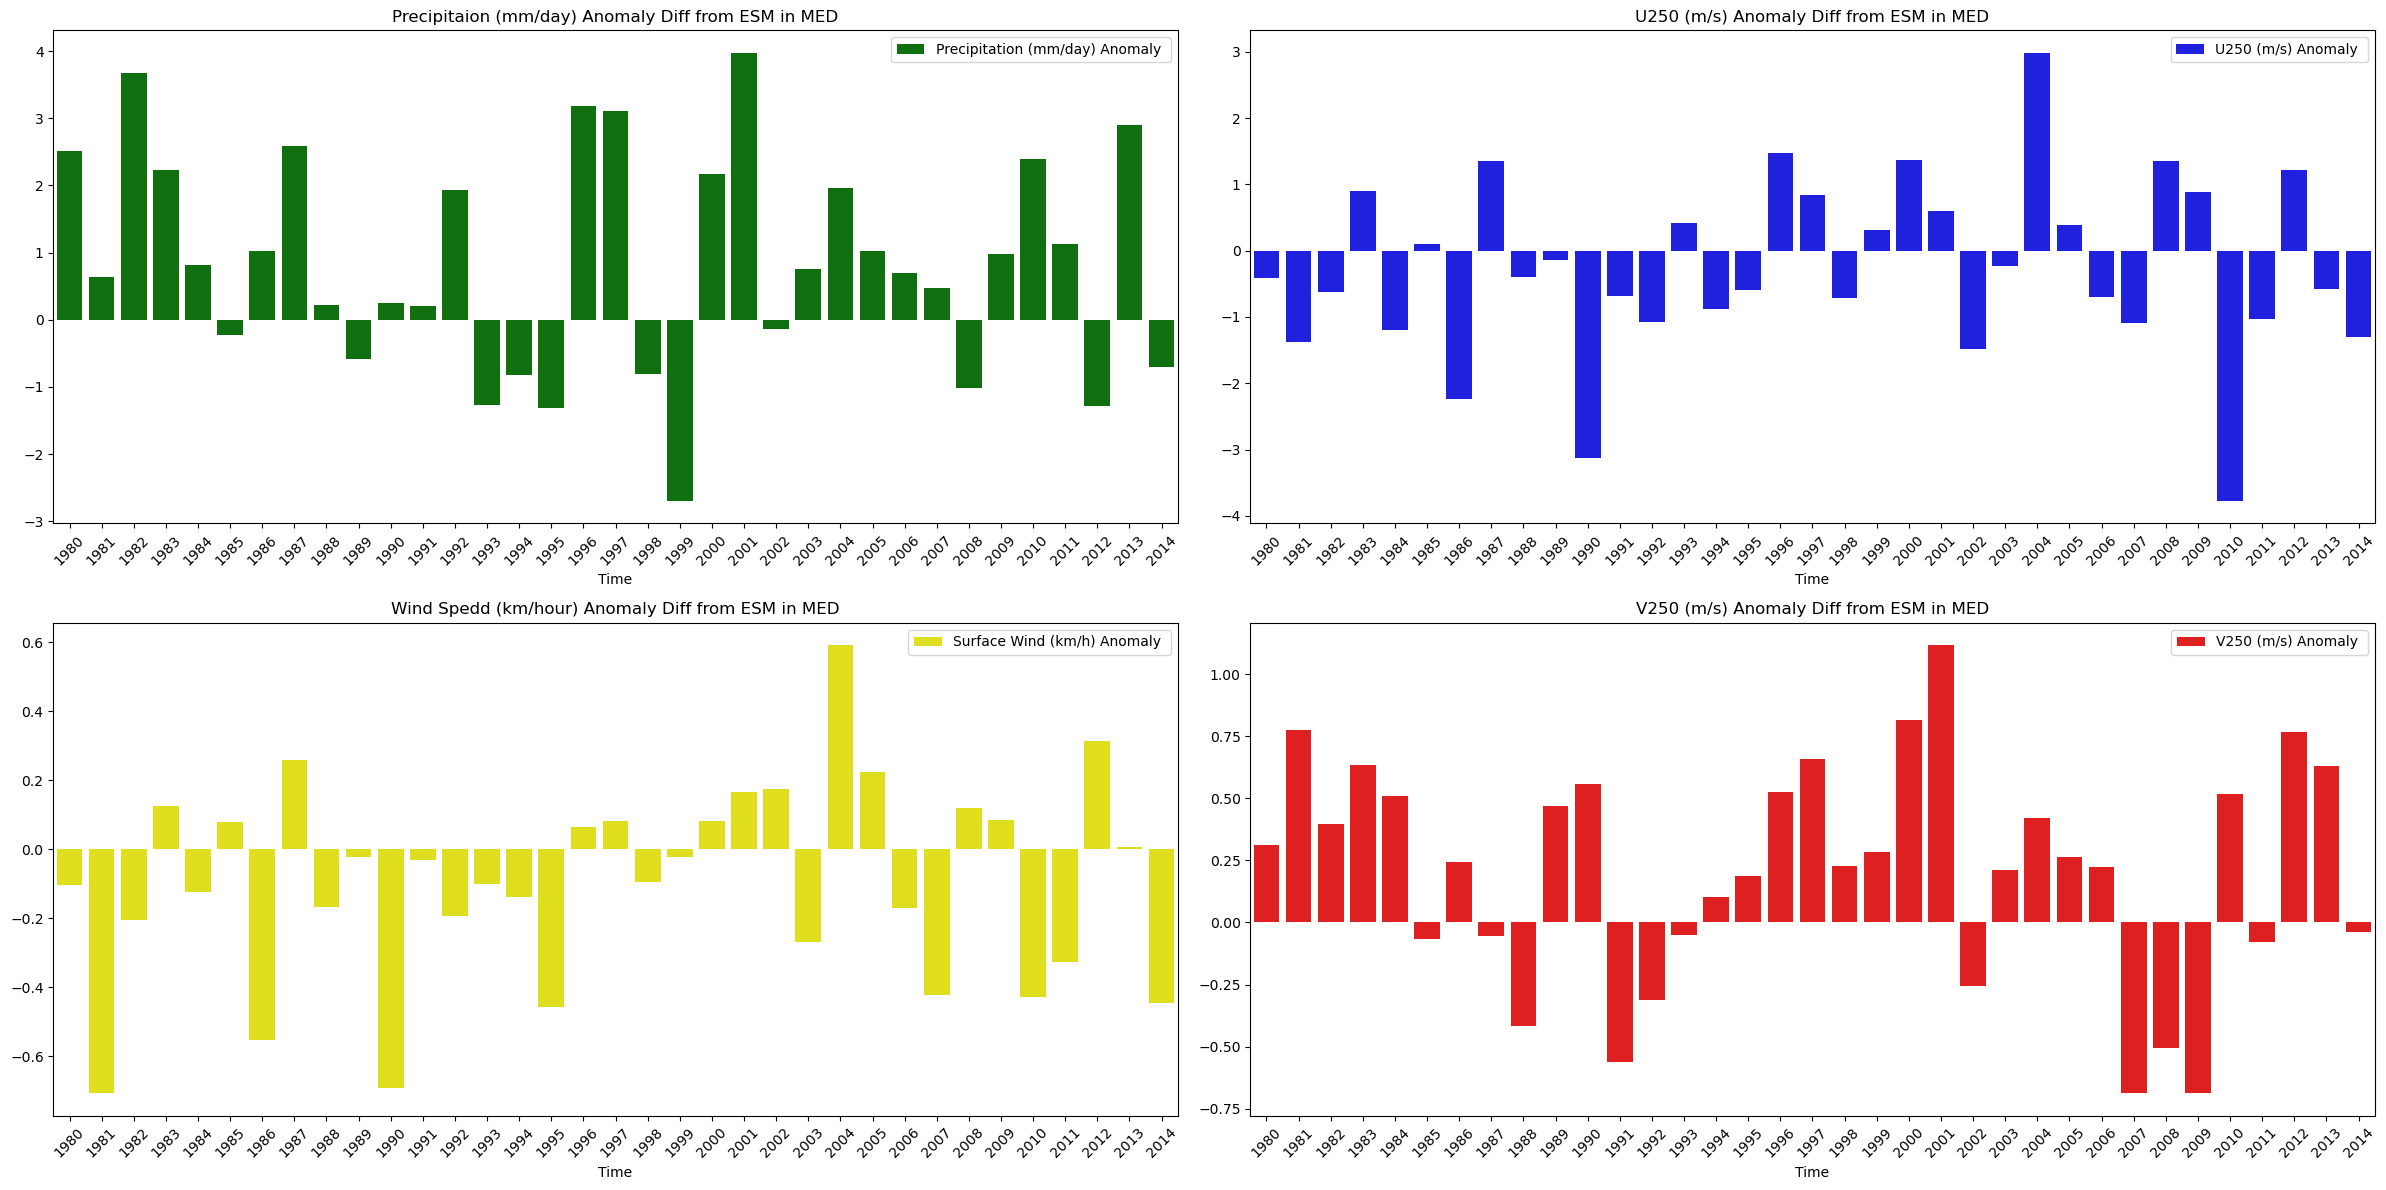

In [182]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(24, 12))

# Barplots
sns.barplot(x=time, y=diff_precip, label='Precipitation (mm/day) Anomaly ', color='green', ax=ax[0,0])
sns.barplot(x=time, y=diff_sfw, label='Surface Wind (km/h) Anomaly ', color='yellow', ax=ax[1,0])
sns.barplot(x=time, y=diff_u250, label='U250 (m/s) Anomaly ', color='blue', ax=ax[0,1])
sns.barplot(x=time, y=diff_v250, label='V250 (m/s) Anomaly ', color='red', ax=ax[1,1])

# Set x-axis labels and rotate ticks for readability
ax[0,0].set_xlabel('Time')
ax[1,0].set_xlabel('Time')
ax[0,0].title.set_text('Precipitaion (mm/day) Anomaly Diff from ESM in MED')
ax[1,0].title.set_text('Wind Spedd (km/hour) Anomaly Diff from ESM in MED')
ax[0,1].set_xlabel('Time')
ax[1,1].set_xlabel('Time')
ax[0,1].title.set_text('U250 (m/s) Anomaly Diff from ESM in MED')
ax[1,1].title.set_text('V250 (m/s) Anomaly Diff from ESM in MED')
for a in ax.flatten():
    for label in a.get_xticklabels():
        label.set_rotation(45)
    a.set_xticks(a.get_xticks()[::max(1, len(a.get_xticks())//25)])  # Reduce number of ticks if too many

plt.tight_layout()
plt.show()

In [180]:
from torchsummary import summary

# Example input shape: (channels, height, width) = (2, 32, 64)
summary(model, input_size=(2, 32, 64))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 64]             608
              ReLU-2           [-1, 32, 32, 64]               0
            Conv2d-3           [-1, 64, 32, 64]          18,496
              ReLU-4           [-1, 64, 32, 64]               0
            Conv2d-5           [-1, 32, 32, 64]          18,464
              ReLU-6           [-1, 32, 32, 64]               0
            Conv2d-7            [-1, 4, 32, 64]             132
Total params: 37,700
Trainable params: 37,700
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 4.06
Params size (MB): 0.14
Estimated Total Size (MB): 4.22
----------------------------------------------------------------
PCtoAnomalyCNN(
  (cnn): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [183]:
precip_test=precip_df.sel(time=slice("1980", "2014"))["pr"].values
surf_wind_test=surf_wind_df.sel(time=slice("1980", "2014"))["sfcWind"].values
u250_test=u250_df.sel(time=slice("1980", "2014"))["ua"].values
v250_test=v250_df.sel(time=slice("1980", "2014"))["va"].values

In [195]:
X_val_tensor = new_input_tensor

Y_val = np.stack([precip_test, surf_wind_test, u250_test, v250_test], axis=1)
Y_val_tensor = torch.from_numpy(Y_val).float()
Y_val_tensor_resized = F.interpolate(Y_val_tensor, size=(32, 64), mode='bilinear', align_corners=False)

In [199]:
import torch

def pearson_corr_torch(x, y, eps=1e-8):
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)
    xm = x - mean_x
    ym = y - mean_y
    r_num = torch.sum(xm * ym)
    r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2))
    return (r_num / (r_den + eps)).item()

with torch.no_grad():
    pred = pred       # shape [N, C, H, W]
    y_true = Y_val_tensor_resized            # same shape

    n_channels = pred.shape[1]

    rmse_per_channel = []
    mae_per_channel = []
    corr_per_channel = []

    for c in range(n_channels):
        p = pred[:, c, :, :]
        t = y_true[:, c, :, :]

        mse = torch.mean((p - t) ** 2)
        rmse = torch.sqrt(mse).item()
        mae = torch.mean(torch.abs(p - t)).item()

        # Flatten spatial and batch dims for correlation
        p_flat = p.reshape(-1)
        t_flat = t.reshape(-1)
        corr = pearson_corr_torch(p_flat, t_flat)

        rmse_per_channel.append(rmse)
        mae_per_channel.append(mae)
        corr_per_channel.append(corr)

    print(f"Validation RMSE per channel: {rmse_per_channel}")
    print(f"Validation MAE per channel: {mae_per_channel}")
    print(f"Validation Pearson Correlation per channel: {corr_per_channel}")

Validation RMSE per channel: [4.1438984870910645, 0.6087947487831116, 2.062950611114502, 1.4213124513626099]
Validation MAE per channel: [3.263211488723755, 0.46423134207725525, 1.634621262550354, 1.1341824531555176]
Validation Pearson Correlation per channel: [0.22320039570331573, 0.22316408157348633, 0.14432036876678467, 0.08884899318218231]
